#### Model Understanting

In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models

# apesar de incluido no enviromnent.yml
# o captum não estava sendo reconhecido
%pip install captum -qU
import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import os, sys
import json

import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

Note: you may need to restart the kernel to use updated packages.


In [2]:
model = models.resnet101(weights='DEFAULT')
model = model.eval()

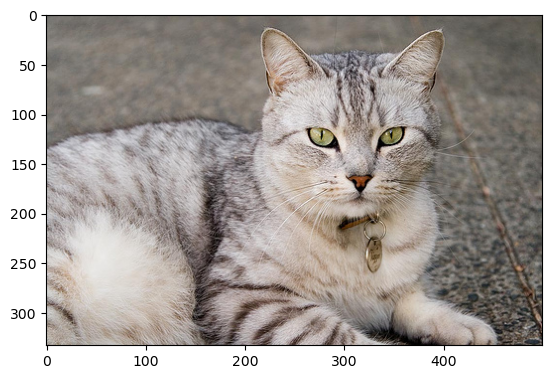

In [3]:
test_img = Image.open('img/cat.jpg')
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.show()

In [4]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
    mean = [0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

print(test_img_data.shape)

transformed_img = transform(test_img)
input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(0) # add one dimension

labels_path = 'img/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)



(333, 500, 3)


In [5]:
output = model(input_img)
output = F.softmax(output, dim =1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')


Predicted: Egyptian_cat ( 0.824128270149231 )


Feature Attribution with Integrated Gradients

In [6]:
integrated_gradients = IntegratedGradients(model)

# comando extremamente demorado (demorou 45 minutos 200 step)
# TODO tentar rodar com menos para ver se é suficiente.
attributions_ig = integrated_gradients.attribute(input_img, target=pred_label_idx, n_steps=200)

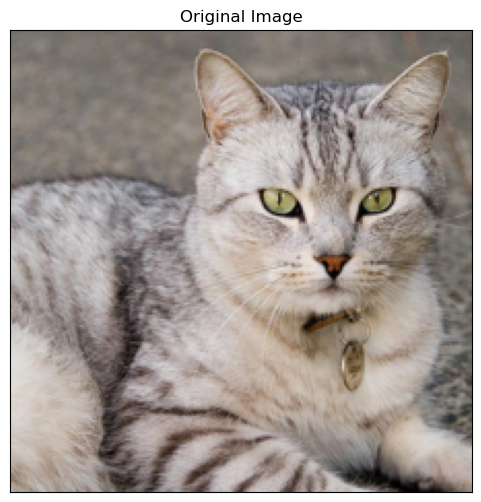

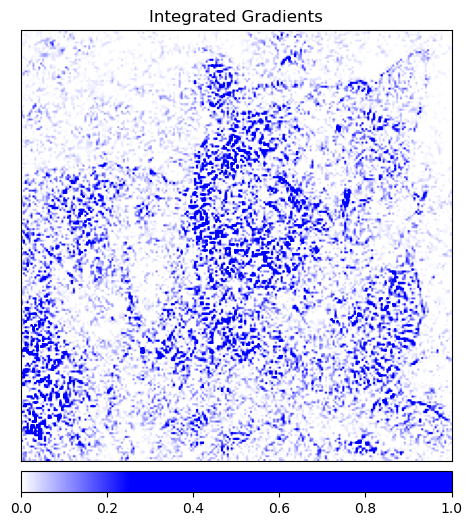

In [7]:
_ = viz.visualize_image_attr(None, np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    method = "original_image", title = 'Original Image')

default_cmp = LinearSegmentedColormap.from_list('custom_blue',
                                                [(0, '#ffffff'),
                                                 (0.25, '#0000ff'),
                                                 (1, '#0000ff')], N = 256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1, 2, 0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1, 2, 0)),
                             method='heat_map',
                             cmap=default_cmp,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')

##### Feature Attribution with Occlusion

In [8]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input_img,
                                       target=pred_label_idx,
                                       strides=(3, 8, 8),
                                       sliding_window_shapes=(3, 15,15),
                                       baselines=0)

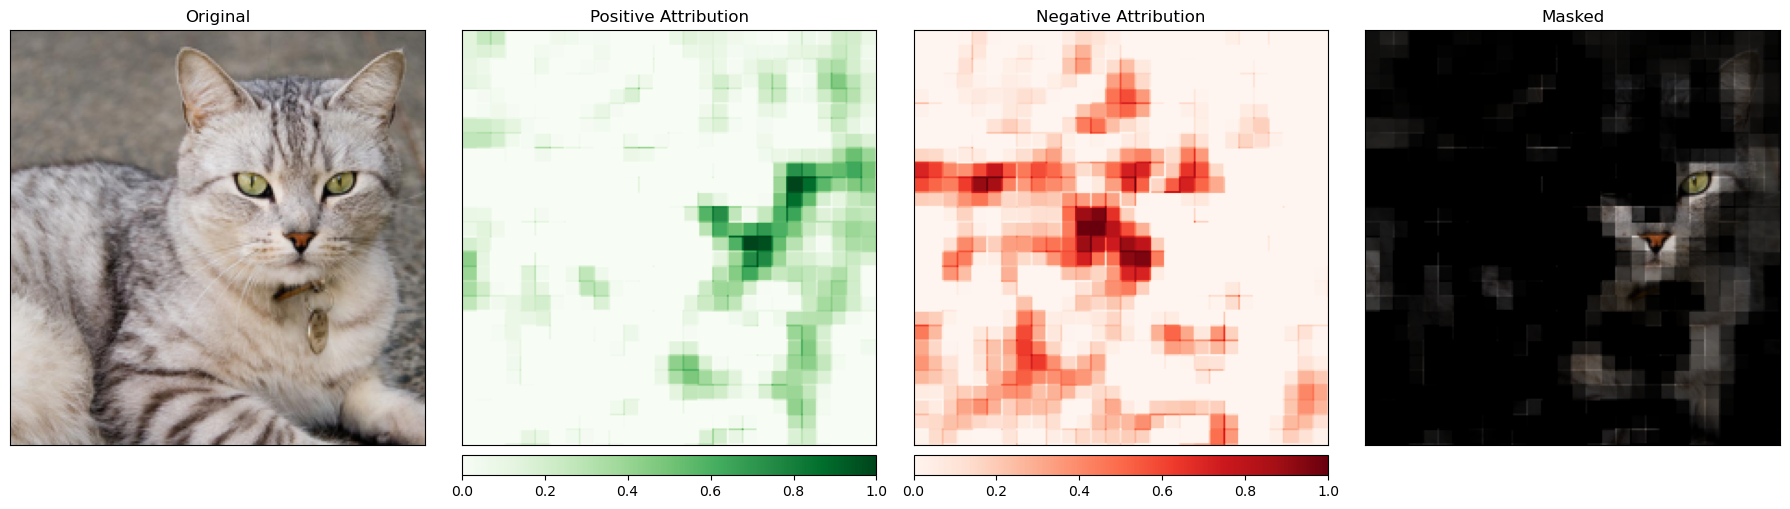

In [9]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map", "heat_map", "masked_image"],
                                      ["all", "positive", "negative", "positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
                                      fig_size=(18, 6)
                                     )

##### Layer Attribution with Layer GradCAM

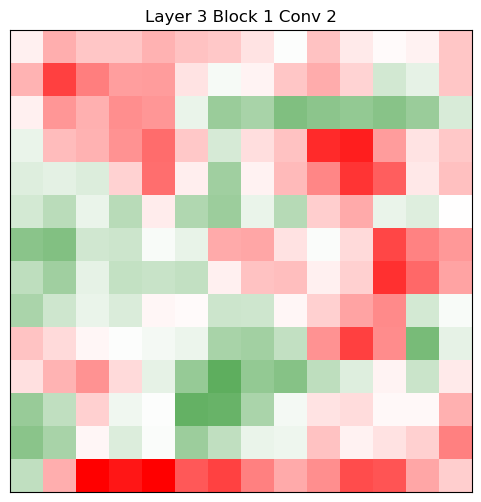

In [10]:
layer_gradcam = LayerGradCam(model, model.layer3[1].conv2)
attributions_lgc = layer_gradcam.attribute(input_img, target=pred_label_idx)

_ = viz.visualize_image_attr(attributions_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                             sign="all",
                             title="Layer 3 Block 1 Conv 2")

torch.Size([1, 1, 14, 14])
torch.Size([1, 1, 224, 224])
torch.Size([1, 3, 224, 224])


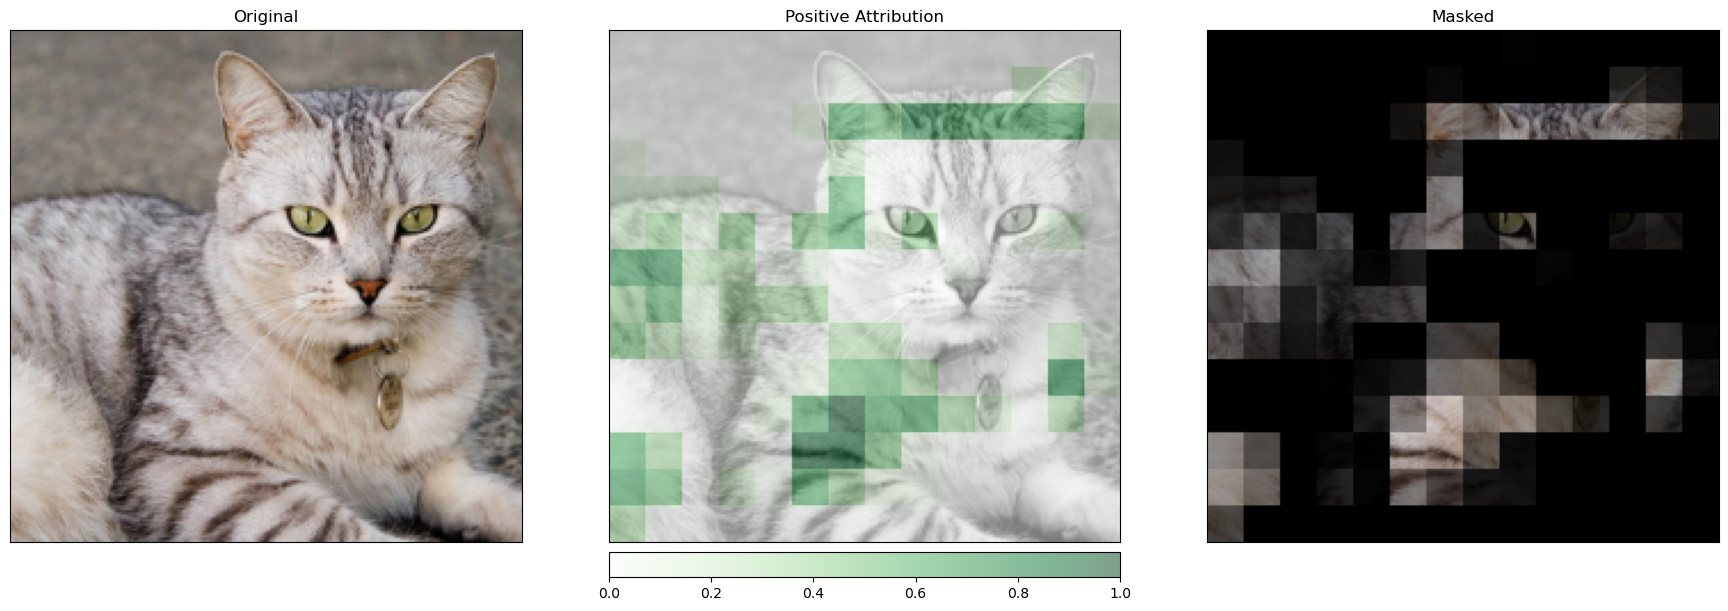

In [11]:
upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, input_img.shape[2:])

print(attributions_lgc.shape)
print(upsamp_attr_lgc.shape)
print(input_img.shape)

_ = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                      transformed_img.permute(1,2,0).numpy(),
                                      ["original_image","blended_heat_map","masked_image"],
                                      ["all","positive","positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Masked"],
                                      fig_size=(18, 6))

##### Visualization with Captum Insights

In [6]:
imgs = ['img/cat.jpg'] #, 'img/teapot.jpg', 'img/trilobite.jpg']

for img in imgs:
    img = Image.open(img)
    transformed_img = transform(img)
    input_img = transform_normalize(transformed_img)
    input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

    output = model(input_img)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()
    predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
    print('Predicted:', predicted_label, '/', pred_label_idx.item(), ' (', prediction_score.squeeze().item(), ')')

Predicted: Egyptian_cat / 285  ( 0.824128270149231 )


In [7]:
# está no environment.yml, mas não está sendo reconhecido
%pip install flask-compress -qU

Note: you may need to restart the kernel to use updated packages.


In [8]:
import importlib.metadata
print(importlib.metadata.version('flask'))
print(importlib.metadata.version('flask_compress'))

3.0.3
1.15


In [9]:
from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature

# Baseline is all-zeros input - this may differ depending on your data
def baseline_func(input):
    return input * 0

# merging our image transforms from above
def full_img_transform(input):
    i = Image.open(input)
    i = transform(i)
    i = transform_normalize(i)
    i = i.unsqueeze(0)
    return i


input_imgs = torch.cat(list(map(lambda i: full_img_transform(i), imgs)), 0)

visualizer = AttributionVisualizer(
    models=[model],
    score_func=lambda o: torch.nn.functional.softmax(o, 1),
    classes=list(map(lambda k: idx_to_labels[k][1], idx_to_labels.keys())),
    features=[
        ImageFeature(
            "Photo",
            baseline_transforms=[baseline_func],
            input_transforms=[],
        )
    ],
    dataset=[Batch(input_imgs, labels=[282,849,69])]
)

In [10]:
# https://github.com/pytorch/captum/issues/638
# TODO não está funcionando no vscode
visualizer.render(debug = True)

CaptumInsights(insights_config={'classes': ['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhe…

Output()